**BART NEW**

In [6]:
!pip install torch numpy pandas nltk rouge-score transformers gensim tqdm matplotlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BartTokenizer, BartForConditionalGeneration, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import rouge_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set random seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
train_df = pd.read_csv('../data/train.csv', header=None)
test_df = pd.read_csv('../data/test.csv', header=None)
val_df = pd.read_csv('../data/validation.csv', header=None)

columns = ['id', 'article', 'summary']
train_df.columns = columns
test_df.columns = columns
val_df.columns = columns

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    return text

def clean_article_heading(article):
    pattern = r'By\s*\.\s*.*?\s*\.\s*PUBLISHED:\s*\.\s*\d+:\d+\s*EST,\s*\d+\s*[A-Za-z]+\s*\d+\s*\.\s*\|\s*\.\s*UPDATED:\s*\.\s*\d+:\d+\s*EST,\s*\d+\s*[A-Za-z]+\s*\d+\s*\.'
    cleaned_text = re.sub(pattern, '', article)
    return cleaned_text.strip()

train_df['article'] = train_df['article'].apply(preprocess_text)
train_df['article'] = train_df['article'].apply(clean_article_heading)
train_df['summary'] = train_df['summary'].apply(preprocess_text)
test_df['article'] = test_df['article'].apply(preprocess_text)
test_df['article'] = test_df['article'].apply(clean_article_heading)
test_df['summary'] = test_df['summary'].apply(preprocess_text)
val_df['article'] = val_df['article'].apply(preprocess_text)
val_df['article'] = val_df['article'].apply(clean_article_heading)
val_df['summary'] = val_df['summary'].apply(preprocess_text)

print(f"Training dataframe shape: {train_df.shape}")
print(f"Test dataframe shape: {test_df.shape}")
print(f"Validation dataframe shape: {val_df.shape}")

Training dataframe shape: (287114, 3)
Test dataframe shape: (11491, 3)
Validation dataframe shape: (13369, 3)


In [8]:
train_df = train_df.sample(n=20000, random_state=42)
test_df = test_df.sample(n=2000, random_state=42)
val_df = val_df.sample(n=2000, random_state=42)

In [9]:
class NewsDataset(Dataset):
    def __init__(self, articles, summaries, tokenizer, max_length=512):
        self.articles = articles
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        article = str(self.articles[idx])
        summary = str(self.summaries[idx])
        
        article_encoding = self.tokenizer(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        summary_encoding = self.tokenizer(
            summary,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'article_input_ids': article_encoding['input_ids'].flatten(),
            'article_attention_mask': article_encoding['attention_mask'].flatten(),
            'summary_input_ids': summary_encoding['input_ids'].flatten(),
            'summary_attention_mask': summary_encoding['attention_mask'].flatten()
        }

In [10]:
class SummarizationModel(nn.Module):
    """BART-based summarization model."""
    
    def __init__(self, model_name='facebook/bart-base'):
        super(SummarizationModel, self).__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(model_name)
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

def calculate_rouge_scores(predictions, references, rouge_scorer):
    """Calculate ROUGE scores."""
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for pred, ref in zip(predictions, references):
        scores = rouge_scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    
    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        # Move batch to device
        input_ids = batch['article_input_ids'].to(device)
        attention_mask = batch['article_attention_mask'].to(device)
        labels = batch['summary_input_ids'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, tokenizer, device, rouge_scorer_obj):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['article_input_ids'].to(device)
            attention_mask = batch['article_attention_mask'].to(device)
            labels = batch['summary_input_ids'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Generate summaries
            generated_ids = model.bart.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )
            
            # Decode predictions and references
            for i in range(len(generated_ids)):
                pred = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
                ref = tokenizer.decode(labels[i], skip_special_tokens=True)
                
                predictions.append(pred)
                references.append(ref)
    
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(predictions, references, rouge_scorer_obj)
    
    return total_loss / len(dataloader), rouge_scores

def train_model(model, train_dataloader, val_dataloader, tokenizer, device, num_epochs=3, learning_rate=5e-5):
    """Train the model."""
    # Initialize ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    train_losses = []
    val_losses = []
    rouge_scores_history = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        train_losses.append(train_loss)
        
        # Evaluate
        val_loss, rouge_scores = evaluate_model(model, val_dataloader, tokenizer, device, rouge_scorer_obj)
        val_losses.append(val_loss)
        rouge_scores_history.append(rouge_scores)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
    
    return train_losses, val_losses, rouge_scores_history

In [11]:
tokenizer_large = BartTokenizer.from_pretrained('facebook/bart-large')
model_large = SummarizationModel('facebook/bart-large')
model_large = model_large.to(device)

train_dataset_large = NewsDataset(
    train_df['article'].values,
    train_df['summary'].values,
    tokenizer_large
)

val_dataset_large = NewsDataset(
    val_df['article'].values,
    val_df['summary'].values,
    tokenizer_large
)

test_dataset_large = NewsDataset(
    test_df['article'].values,
    test_df['summary'].values,
    tokenizer_large
)

train_loader_large = DataLoader(train_dataset_large, batch_size=8, shuffle=True)
val_loader_large = DataLoader(val_dataset_large, batch_size=8, shuffle=False)
test_loader_large = DataLoader(test_dataset_large, batch_size=8, shuffle=False)

In [12]:
print("\nStarting BART-large training process:")
train_losses_large, val_losses_large, rouge_scores_history_large = train_model(
    model_large, 
    train_loader_large, 
    val_loader_large, 
    tokenizer_large, 
    device, 
    num_epochs=9,
    learning_rate=2e-5 
)

print("\nSaving the BART-large model...")
model_save_path_large = 'best_bart_large_summarization_model.pth'
torch.save({
    'model_state_dict': model_large.state_dict(),
    'tokenizer': tokenizer_large,
    'training_history': {
        'train_losses': train_losses_large,
        'val_losses': val_losses_large,
        'rouge_scores': rouge_scores_history_large
    }
}, model_save_path_large)
print(f"Model saved to {model_save_path_large}")


Starting BART-large training process:

Epoch 1/9


Evaluating: 100%|██████████| 250/250 [05:40<00:00,  1.36s/it]


Train Loss: 1.1926
Val Loss: 0.9322
ROUGE-1: 0.4309
ROUGE-2: 0.2024
ROUGE-L: 0.2929

Epoch 2/9


Evaluating: 100%|██████████| 250/250 [05:10<00:00,  1.24s/it]


Train Loss: 0.8540
Val Loss: 0.9126
ROUGE-1: 0.4316
ROUGE-2: 0.2039
ROUGE-L: 0.2971

Epoch 3/9


Evaluating: 100%|██████████| 250/250 [05:50<00:00,  1.40s/it]


Train Loss: 0.7687
Val Loss: 0.9213
ROUGE-1: 0.4350
ROUGE-2: 0.2070
ROUGE-L: 0.2974

Epoch 4/9


Evaluating: 100%|██████████| 250/250 [04:47<00:00,  1.15s/it]


Train Loss: 0.6990
Val Loss: 0.9360
ROUGE-1: 0.4315
ROUGE-2: 0.2046
ROUGE-L: 0.3000

Epoch 5/9


Evaluating: 100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Train Loss: 0.6420
Val Loss: 0.9522
ROUGE-1: 0.4359
ROUGE-2: 0.2072
ROUGE-L: 0.3019

Epoch 6/9


Evaluating: 100%|██████████| 250/250 [05:01<00:00,  1.20s/it]


Train Loss: 0.5933
Val Loss: 0.9746
ROUGE-1: 0.4314
ROUGE-2: 0.2032
ROUGE-L: 0.3002

Epoch 7/9


Evaluating: 100%|██████████| 250/250 [05:28<00:00,  1.31s/it]


Train Loss: 0.5547
Val Loss: 0.9891
ROUGE-1: 0.4359
ROUGE-2: 0.2051
ROUGE-L: 0.2999

Epoch 8/9


Evaluating: 100%|██████████| 250/250 [05:21<00:00,  1.29s/it]


Train Loss: 0.5244
Val Loss: 1.0067
ROUGE-1: 0.4381
ROUGE-2: 0.2063
ROUGE-L: 0.3013

Epoch 9/9


Evaluating: 100%|██████████| 250/250 [05:19<00:00,  1.28s/it]


Train Loss: 0.5037
Val Loss: 1.0203
ROUGE-1: 0.4394
ROUGE-2: 0.2078
ROUGE-L: 0.3036

Saving the BART-large model...
Model saved to best_bart_large_summarization_model.pth


In [14]:
def plot_training_history(train_losses, val_losses, rouge_scores_history):
    """Plot training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # ROUGE scores
    rouge1_scores = [scores['rouge1'] for scores in rouge_scores_history]
    rouge2_scores = [scores['rouge2'] for scores in rouge_scores_history]
    rougeL_scores = [scores['rougeL'] for scores in rouge_scores_history]
    
    axes[0, 1].plot(rouge1_scores, label='ROUGE-1', marker='o')
    axes[0, 1].plot(rouge2_scores, label='ROUGE-2', marker='s')
    axes[0, 1].plot(rougeL_scores, label='ROUGE-L', marker='^')
    axes[0, 1].set_title('ROUGE Scores')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROUGE Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Final ROUGE scores bar plot
    final_scores = rouge_scores_history[-1]
    rouge_types = list(final_scores.keys())
    scores = list(final_scores.values())
    
    axes[1, 0].bar(rouge_types, scores, color=['blue', 'green', 'red'])
    axes[1, 0].set_title('Final ROUGE Scores')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].grid(True, axis='y')
    
    # Learning curve
    epochs = range(1, len(train_losses) + 1)
    axes[1, 1].plot(epochs, train_losses, 'b-', label='Training Loss')
    axes[1, 1].plot(epochs, val_losses, 'r-', label='Validation Loss')
    axes[1, 1].set_title('Learning Curve')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def generate_summary(model, tokenizer, article, device, max_length=150):
    """Generate summary for a single article."""
    model.eval()
    
    # Tokenize article
    inputs = tokenizer(
        article,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)
    
    # Generate summary
    with torch.no_grad():
        summary_ids = model.bart.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
    
    # Decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


Plotting BART-large training history...


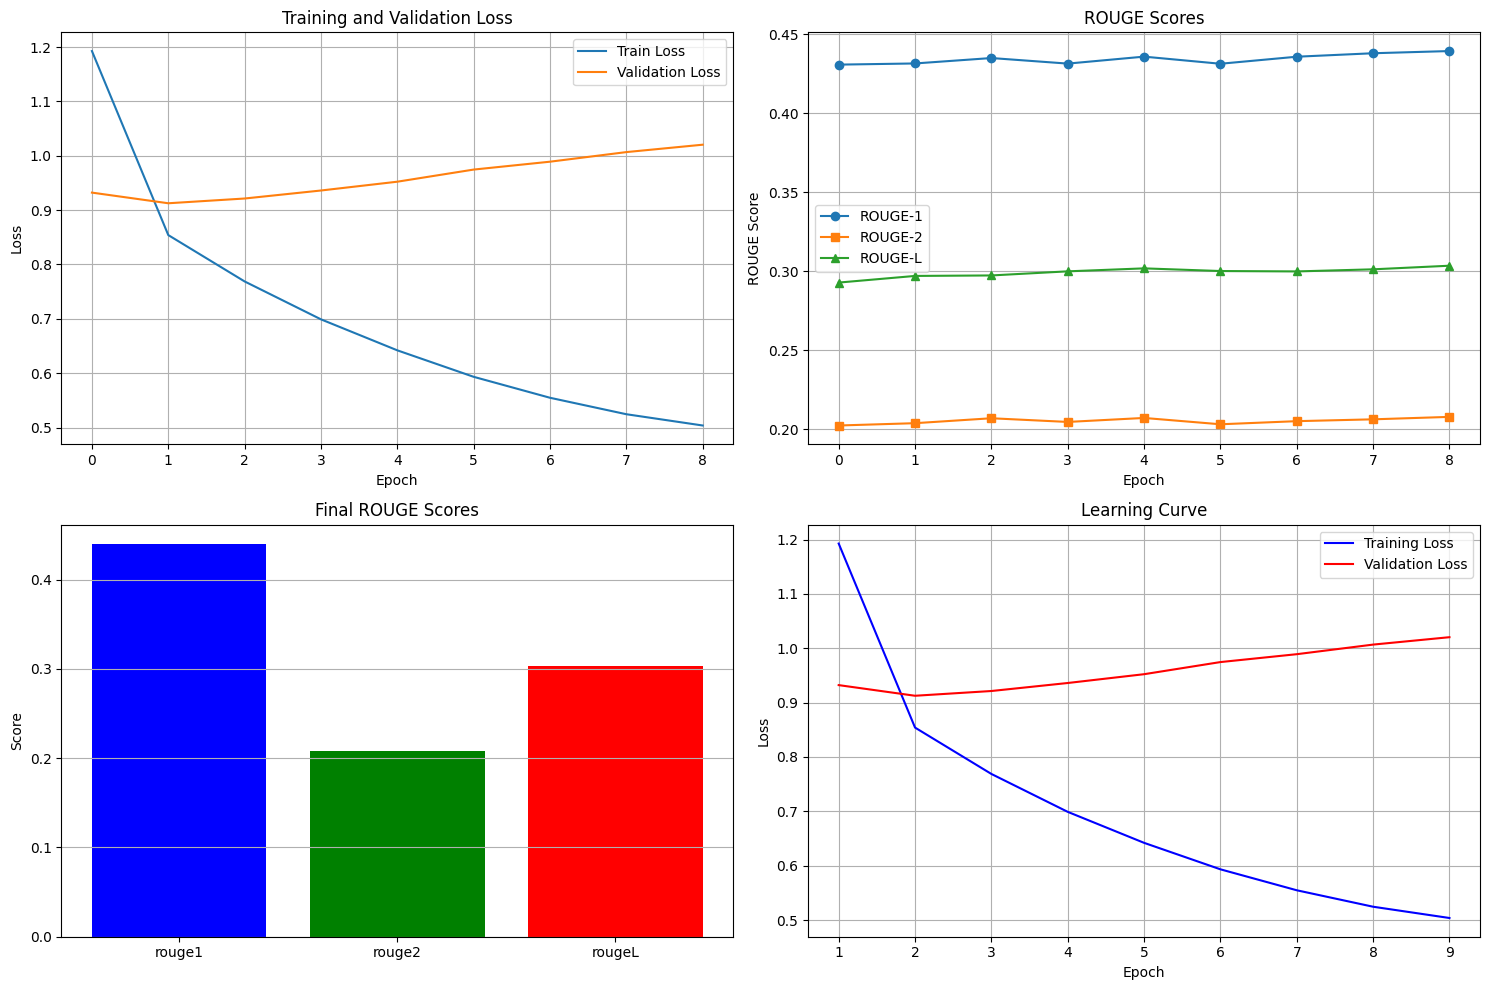

In [15]:
print("\nPlotting BART-large training history...")
plot_training_history(train_losses_large, val_losses_large, rouge_scores_history_large)

In [16]:
print("\nPerforming final evaluation on test data with BART-large")
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
test_loss_large, test_rouge_scores_large = evaluate_model(
    model_large, 
    test_loader_large, 
    tokenizer_large, 
    device, 
    rouge_scorer_obj
)

print("\nFinal Test Results (BART-large):")
print(f"Test Loss: {test_loss_large:.4f}")
print("\nROUGE Scores:")
for metric, score in test_rouge_scores_large.items():
    print(f"{metric}: {score:.6f}")


Performing final evaluation on test data with BART-large


Evaluating: 100%|██████████| 250/250 [05:19<00:00,  1.28s/it]



Final Test Results (BART-large):
Test Loss: 0.9685

ROUGE Scores:
rouge1: 0.432995
rouge2: 0.202479
rougeL: 0.297991


In [ ]:
print("\nBART-large Summarization Examples:")
sample_indices = [0, 1, 2]

for i in sample_indices:
    article = test_articles[i]
    actual_summary = test_summaries[i]
    generated_summary = generate_summary(model_large, tokenizer_large, article, device)
    
    print(f"\n=== Example {i+1} ===")
    print(f"\nOriginal Article (first 200 chars):\n{article[:200]}...")
    print(f"\nActual Summary:\n{actual_summary}")
    print(f"\nGenerated Summary (BART-large):\n{generated_summary}")
    
    # Calculate ROUGE scores
    scores = rouge_scorer_obj.score(actual_summary, generated_summary)
    
    print("\nROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
    print("="*50)